# Rivet style analysis plots in MATPLOTLIB

Easier way to do rivet style final state analysis when only plots required are the final state variables/kinematics.

In [120]:
from dataclasses import dataclass
from typing import Tuple, List, Union

import matplotlib.pyplot as plt
import numpy as np
import random


import pyhepmc 
from pyhepmc import GenEvent, FourVector, GenParticle
from pyhepmc.io import ReaderAsciiHepMC2, WriterAsciiHepMC2



First define functions for the logic of the final state particles that returns the final state particles and anonther for reading a the input file(s) and retrieveing and store the 4-momentum of all final state particles. 

In [2]:
def final_state_logic(event : GenEvent) -> List[GenParticle]:
    """Given an input of a GenEvent from a HEPMC introduces the logic to find the 2 final state electrons 
        from the Drell-Yan Z -> ee process. Very simple logic requiring a Z boson with 2 final state electrons
        coming from its end vertex.
    """
    e_pair = list()
    for particles in event.particles:
        # Check for Z boson
        if particles.pid == 23:
            end_vertex = particles.end_vertex
            if end_vertex.particles_out is None:
                continue
            # Loop through daughters of its end vertex
            for daughter_particles in end_vertex.particles_out:
                if abs(daughter_particles.pid) == 11 and daughter_particles.status == 1:
                    e_pair.append(daughter_particles)
    return e_pair

def read_hepmc_file_get_final_states(input_file: str) -> List[List[GenParticle]]:
    """Function to read a single hepmc file, read all the events and extact
        the final state electron pairs from each event.
        Args:    
            input_file (str) : name/location of input file
        Returns:
            List[List[GenParicle]]: Each list entry is a list of GenParitcles 
                from a singular event.
    """
    # Create pyhepmc GenEvent to be able to read in the Event Gen
    event = GenEvent()
    electron_pairs = []
    with ReaderAsciiHepMC2(input_file) as reader:
        # Continues untill all events are read, if a standarad open data single 
        # file this would be 10,000 events
        while not reader.failed():
            if reader.failed():
                break
            reader.read_event(event)

            candidate_pair = final_state_logic(event)
            # Stop empty events appending
            if candidate_pair:
                electron_pairs.append(candidate_pair)
    return electron_pairs

def read_get_final_states(input_files: Union[str, List[str]]) -> List[Tuple[GenParticle]]:
    """Function that either reads in a Lit of strings or a string of a file name 
        that corresponds to a HEPMC - no name checking logic involved as 
        reader in read_hepmc_file will fail if it is not anyway
        Args:
            input_files : either a str or a list of strings
        Returns:
            List[List[GenParicle]]: Each list entry is a list of GenParitcles 
            from a singular event.
    """
    ## This ensures the logic is the same for either string or list input
    files = input_files if isinstance(input_files, list) else [input_files]

    four_momenta = []
    
    for file in files:
        four_momenta += read_hepmc_file_get_final_states(file)
    return four_momenta
   

Now that we have the functions to read the files and get the final state particles we know need functions to easily make plots.

In [6]:
particles = read_get_final_states("../DATA/HEPMC.43646139._000001.hepmc")

In [155]:
@dataclass
class PlotConfiguration:
    xlabel: str
    ylabel: str
    title: str
    legend: str
    range: tuple[int, int]

    figsize: tuple[int, int] = (8, 6)


@dataclass
class HistConfigurations(PlotConfiguration):
    bins: int = 100
    height_ratios: tuple[int, int] = (9, 2)
    
    hist_type: str = "step"

def make_invariant_mass_plots(particle_lists: List[List[GenParticle]], 
                             config: HistConfigurations) -> None:
    """ Function to create histogram plots using distributions, either takes 1 or 2 
    particle lists as input, if 1 produces a singular plot of a histogram, if 2 makes overlapping
    histogram plots on top panel and ratio plot on the smaller bottom panel.

    Calculates invariant mass of each lepton pair and stores in an array.

    If one input so particle_list[0][0] is a GenParticle turn into a list of lists of lists for 
    homogenity.

    """
    # Check number of distributions
    if particle_lists is None:
        raise AttributeError("Particle list is empty")
    if isinstance(particle_lists[0][0], GenParticle):
        print("Is a genparticle")
        raw_particle_lists = [particle_lists]
        num_dist = 1
    else:
        if len(particle_lists) > 2:
            raise AttributeError("Maximum 2 distibutions allowed")
        raw_particle_lists = particle_lists
        num_dist = 2
    
    # Calculate invariant mass of both distributions
    ### To DO : Make this part modular such that any distrubution desired could be easily plotted.
    invariant_masses = []
    for lists in raw_particle_lists:
        l = []
        for pair in lists:
            if len(pair) != 2:
                continue
            combined_four_momentum = pair[0].momentum + pair[1].momentum
            inv_mass = combined_four_momentum.m() *  random.uniform(0.8, 1.2)
            l.append(inv_mass)
        invariant_masses.append(l)
    ratios = []

    # Create invariant mass
    for lists in invariant_masses:
        for i, mass_0 in enumerate(lists):
            mass_1 = invariant_masses[1][i]
            if mass_0 != 0:
                ratio = mass_1 / mass_0
            else:
                continue
            ratios.append(ratio)


    fig = plt.figure(figsize = config.figsize)
    if num_dist == 1:
        pass
    else:
        gs = fig.add_gridspec(2, 1, height_ratios=config.height_ratios, hspace=0)
        
        ax_top = fig.add_subplot(gs[0])
        ax_bot = fig.add_subplot(gs[1], sharex=ax_top)

        ax_top.hist(invariant_masses[0],
                    bins = 100,
                    range = config.range,
                    histtype=config.hist_type,
                    label = "Distribution 1")
        ax_top.hist(invariant_masses[1], 
                    bins = 100,
                    range = config.range,
                    histtype=config.hist_type,
                    label = "Distribution 2")
        
        ax_top.legend()

        
        ax_top.set_xlabel(r"Invariant Mass $m_{ll}$")
        ax_top.set_ylabel(f"Events per {(400000-200000)/100 : .0f} MeV")
        ax_top.set_yscale("log")

        ax_bot.set_ylabel(r"$\frac{m_{1}}{m_{2}}$", rotation = 0, size = 15, labelpad= 20
                          )
        ax_bot.hist(ratios)
        

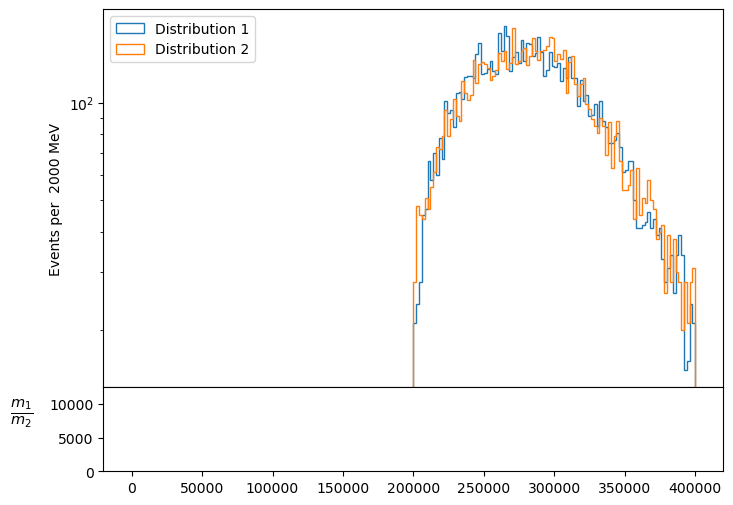

In [156]:
hist_config = HistConfigurations(r"Invariant mass $m_{ll}$", 
                                "Counts",
                                "Histrogram of invariant mass",
                                legend = "",
                                range = (200000, 400000))

make_invariant_mass_plots([particles, particles], hist_config)